In [1]:
import numpy as np
import pandas as pd
import sys
import scipy.io
import matplotlib.pyplot as plt
from tools import * 
from utils import *
import seaborn as sns


# Choose dataset

In [2]:
dataset = 'M027_2024_03_20_11_30'
mouse_id = 'M027'
probe_id = '1'


In [3]:
data_dir = '/data/mouse_data/processed/'+mouse_id+'/'+dataset+'/'+dataset+'_ephys/'+dataset+'_g0/'+dataset+'_g0_imec'+probe_id+'/sorter_output/'
sys.path.append(data_dir)
#import params

In [4]:
ops = np.load(data_dir+'ops.npy', allow_pickle=True).item()
camps = pd.read_csv(data_dir+'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
contam_pct = pd.read_csv(data_dir+'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
chan_map =  np.load(data_dir+'channel_map.npy')
templates =  np.load(data_dir+'templates.npy')
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]
labels = pd.read_csv(data_dir+'cluster_KSLabel.tsv', sep='\t') # label for each cluster (can be good, or multiunit activity --mua)
amplitudes = np.load(data_dir+'amplitudes.npy')
st = np.load(data_dir+'spike_times.npy')# time when spike happened. to transform into seconds 
clu = np.load(data_dir+'spike_clusters.npy') # cluster identity of each spike
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
sys.path.append(data_dir)

#sample_rate = params.sample_rate
dshift = ops['dshift']


# Look at data 

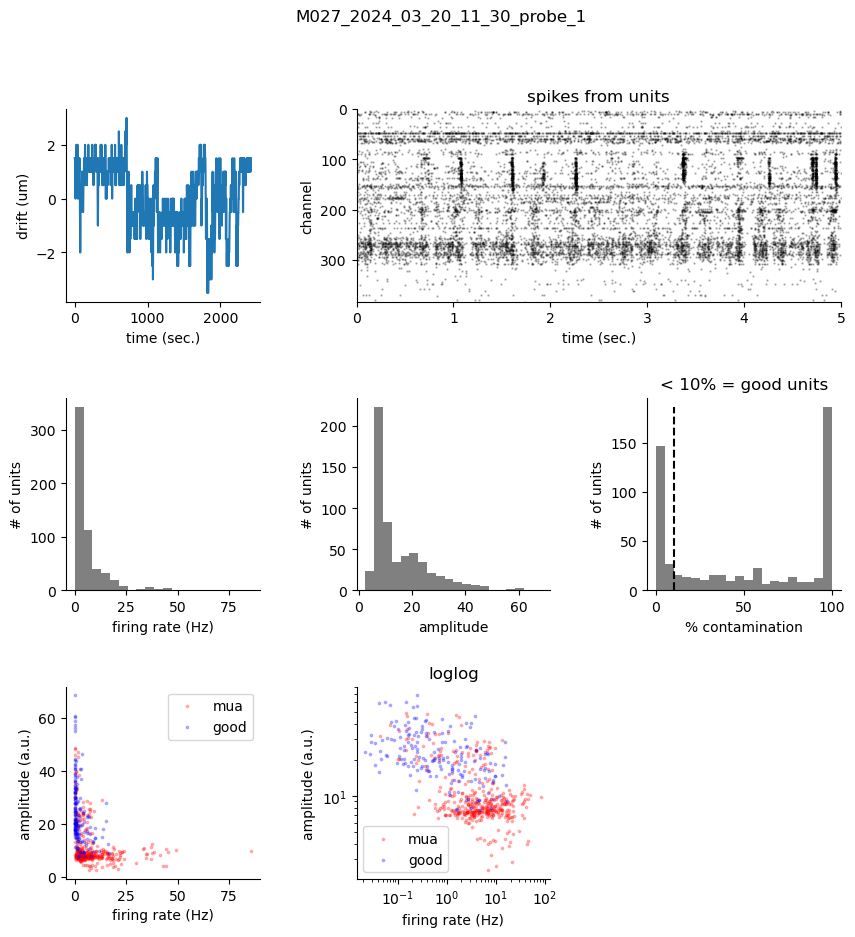

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)

fig = plt.figure(figsize=(10,10), dpi=100)
grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

ax = fig.add_subplot(grid[0,0])
ax.plot(np.arange(0, ops['Nbatches'])*2, dshift);
ax.set_xlabel('time (sec.)')
ax.set_ylabel('drift (um)')

ax = fig.add_subplot(grid[0,1:])
t0 = 0
t1 = np.nonzero(st > ops['fs']*5)[0][0]
ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
ax.set_xlim([0, 5])
ax.set_ylim([chan_map.max(), 0])
ax.set_xlabel('time (sec.)')
ax.set_ylabel('channel')
ax.set_title('spikes from units')

ax = fig.add_subplot(grid[1,0])
nb=ax.hist(firing_rates, 20, color=gray)
ax.set_xlabel('firing rate (Hz)')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,1])
nb=ax.hist(camps, 20, color=gray)
ax.set_xlabel('amplitude')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,2])
nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
ax.plot([10, 10], [0, nb[0].max()], 'k--')
ax.set_xlabel('% contamination')
ax.set_ylabel('# of units')
ax.set_title('< 10% = good units')

for k in range(2):
    ax = fig.add_subplot(grid[2,k])
    is_ref = contam_pct<10.
    ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
    ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_xlabel('firing rate (Hz)')
    ax.legend()
    if k==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('loglog')

plt.suptitle(dataset+'_probe_'+probe_id)

plt.savefig('./probe_analysis/kilosort_comparison/neuron_stats/'+dataset+'_probe_'+probe_id+'_KS4012.pdf')


~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


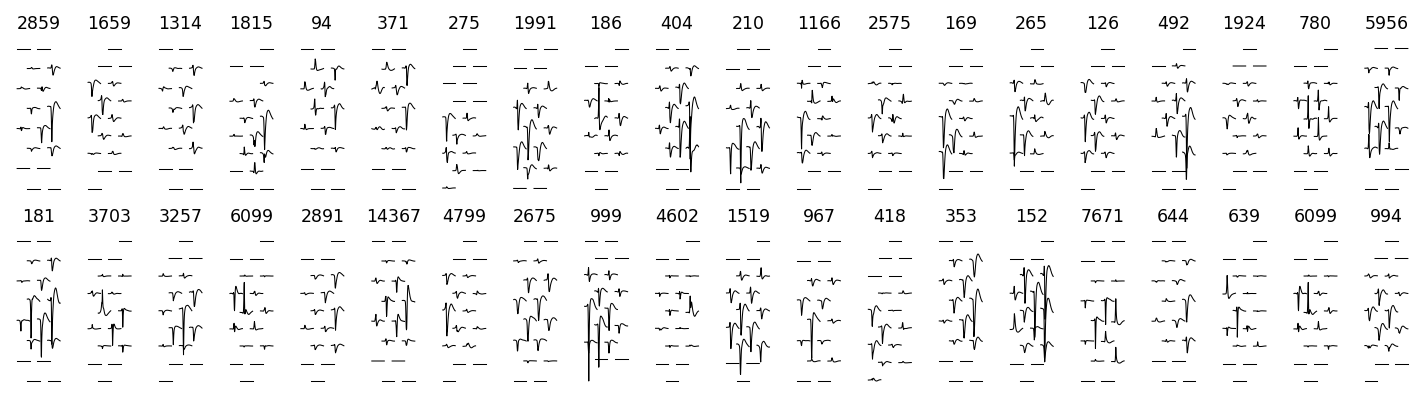

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


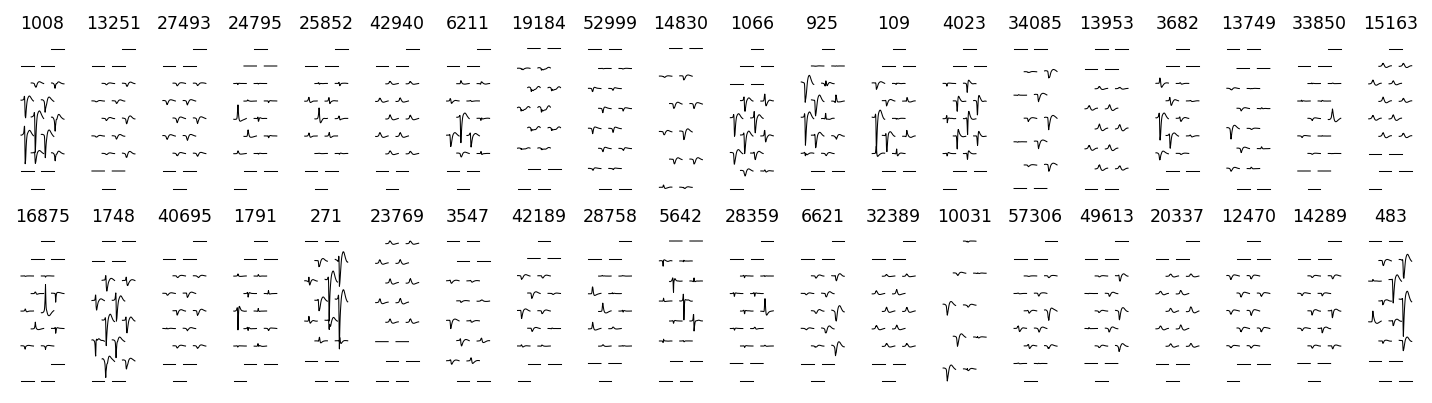

Text(0.5, 0.98, 'M027_2024_03_20_11_30_probe_0')

<Figure size 640x480 with 0 Axes>

In [93]:
probe = ops['probe']
# x and y position of probe sites
xc, yc = probe['xc'], probe['yc']
nc = 16 # number of channels to show
good_units = np.nonzero(contam_pct <= 0.1)[0]
mua_units = np.nonzero(contam_pct > 0.1)[0]


gstr = ['good', 'mua']
for j in range(2):
    print(f'~~~~~~~~~~~~~~ {gstr[j]} units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('title = number of spikes from each unit')
    units = good_units if j==0 else mua_units
    fig = plt.figure(figsize=(12,3), dpi=150)
    grid = gridspec.GridSpec(2,20, figure=fig, hspace=0.25, wspace=0.5)

    for k in range(40):
        wi = units[np.random.randint(len(units))]
        wv = templates[wi].copy()
        cb = chan_best[wi]
        nsp = (clu==wi).sum()

        ax = fig.add_subplot(grid[k//20, k%20])
        n_chan = wv.shape[-1]
        ic0 = max(0, cb-nc//2)
        ic1 = min(n_chan, cb+nc//2)
        wv = wv[:, ic0:ic1]
        x0, y0 = xc[ic0:ic1], yc[ic0:ic1]

        amp = 4
        for ii, (xi,yi) in enumerate(zip(x0,y0)):
            t = np.arange(-wv.shape[0]//2,wv.shape[0]//2,1,'float32')
            t /= wv.shape[0] / 20
            ax.plot(xi + t, yi + wv[:,ii]*amp, lw=0.5, color='k')

        ax.set_title(f'{nsp}', fontsize='small')
        ax.axis('off')
    plt.show()

plt.suptitle(dataset+'_probe_'+probe_id)


#plt.savefig('./probe_analysis/kilosort_comparison/waveforms/'+dataset+'_probe_'+probe_id+'_KS4012.png')


# Create data where each cluster (unit) is a row

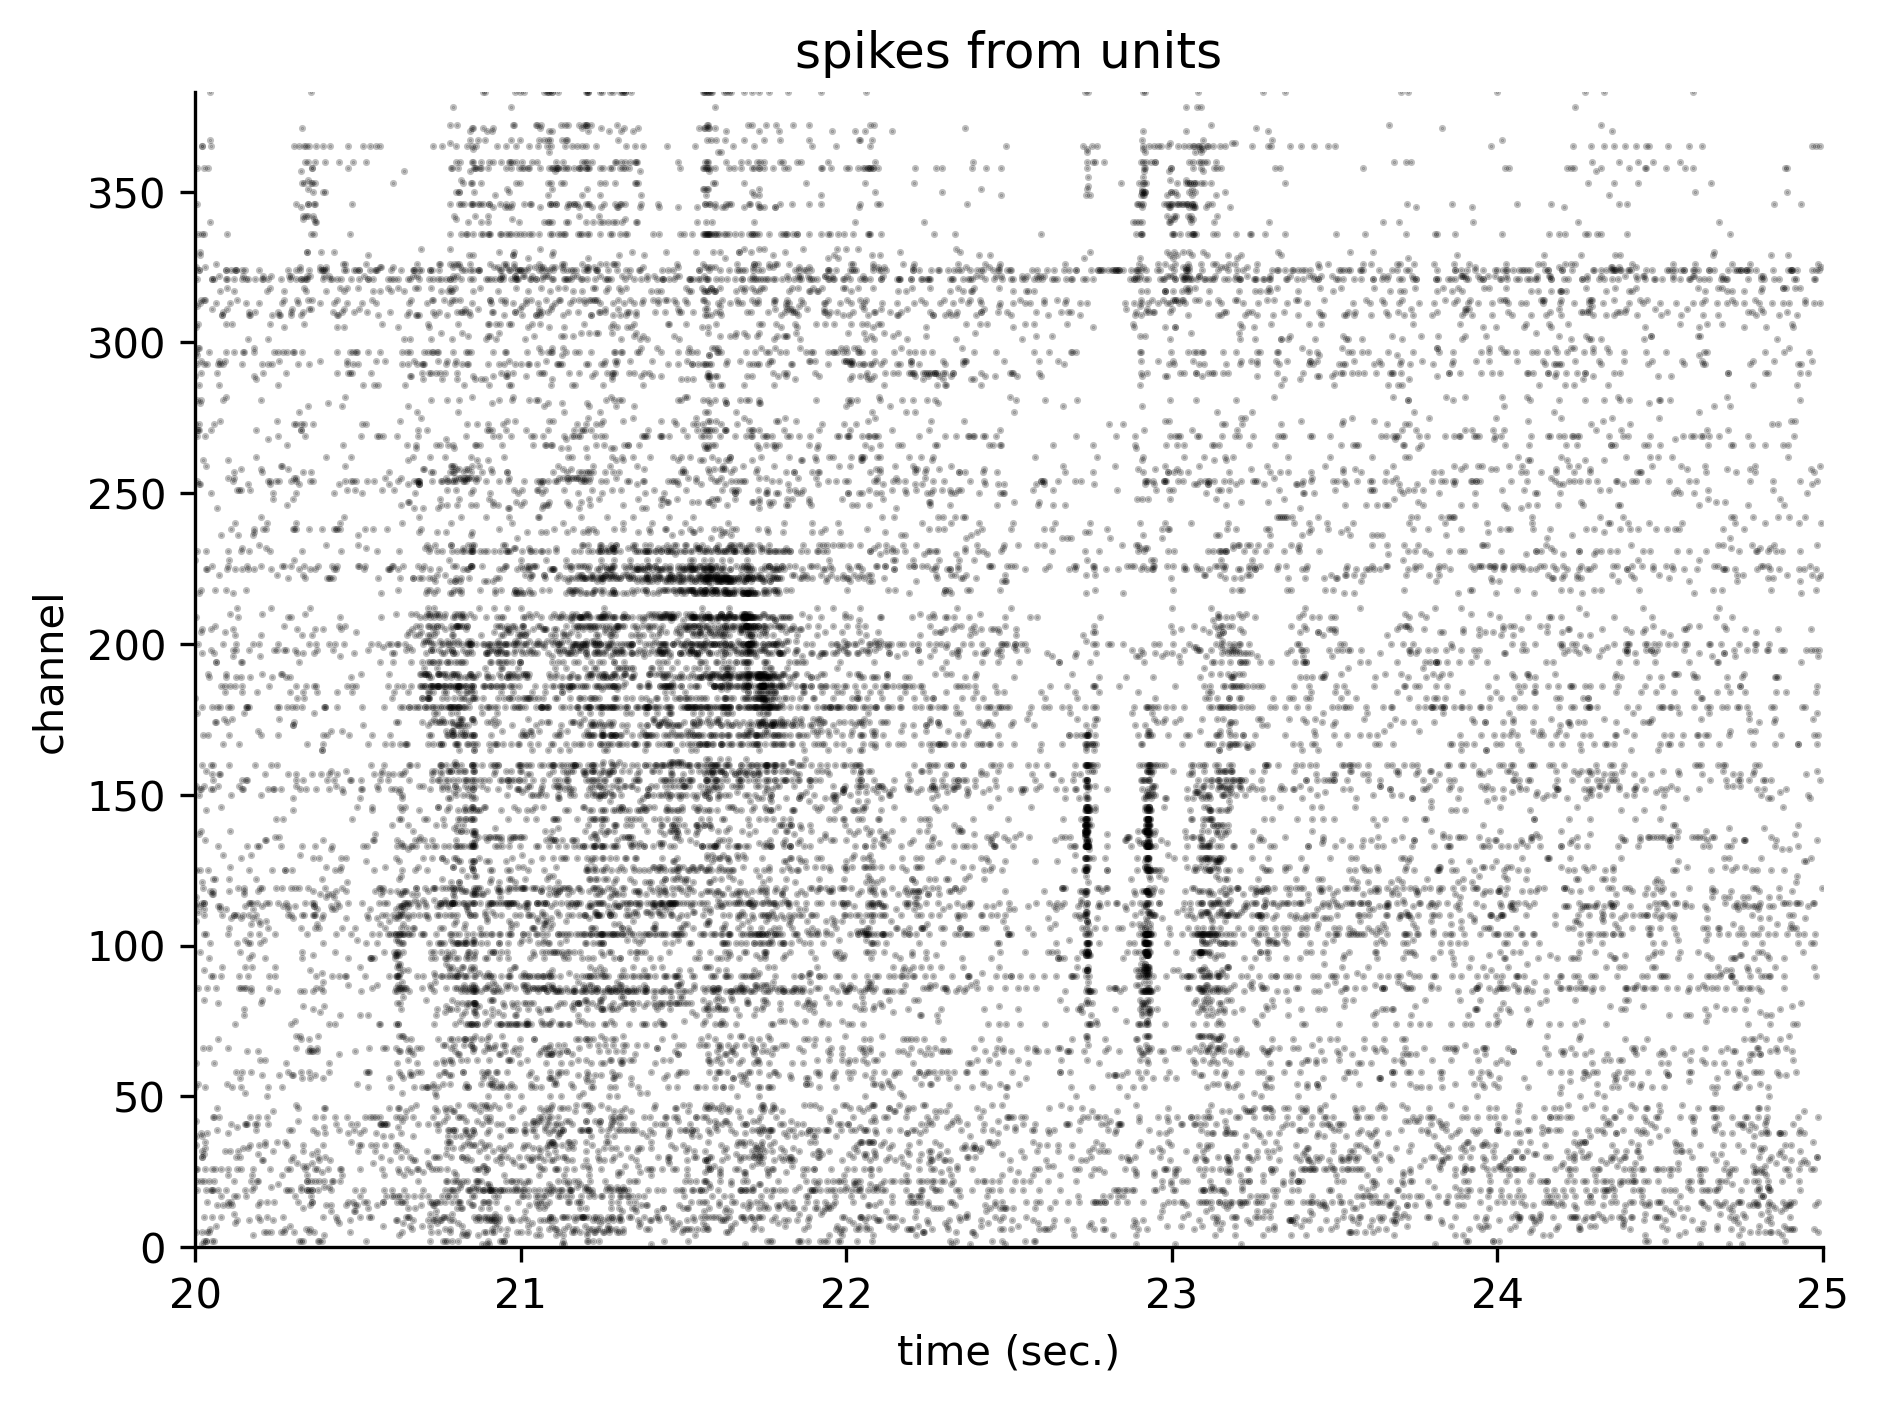

In [97]:
sec_start = 20
sec_end = 25

fig = plt.figure(figsize=(7,5), dpi=300)


t0 = np.nonzero(st > ops['fs']*sec_start)[0][0]
t1 = np.nonzero(st > ops['fs']*sec_end)[0][0]
plt.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
plt.xlim([sec_start, sec_end])
plt.ylim([ 0, chan_map.max()])
plt.xlabel('time (sec.)')
plt.ylabel('channel')
plt.title('spikes from units')

plt.savefig('./probe_analysis/raster_plots/'+dataset+'_probe_'+probe_id+'_spontaneous_beggining.pdf')


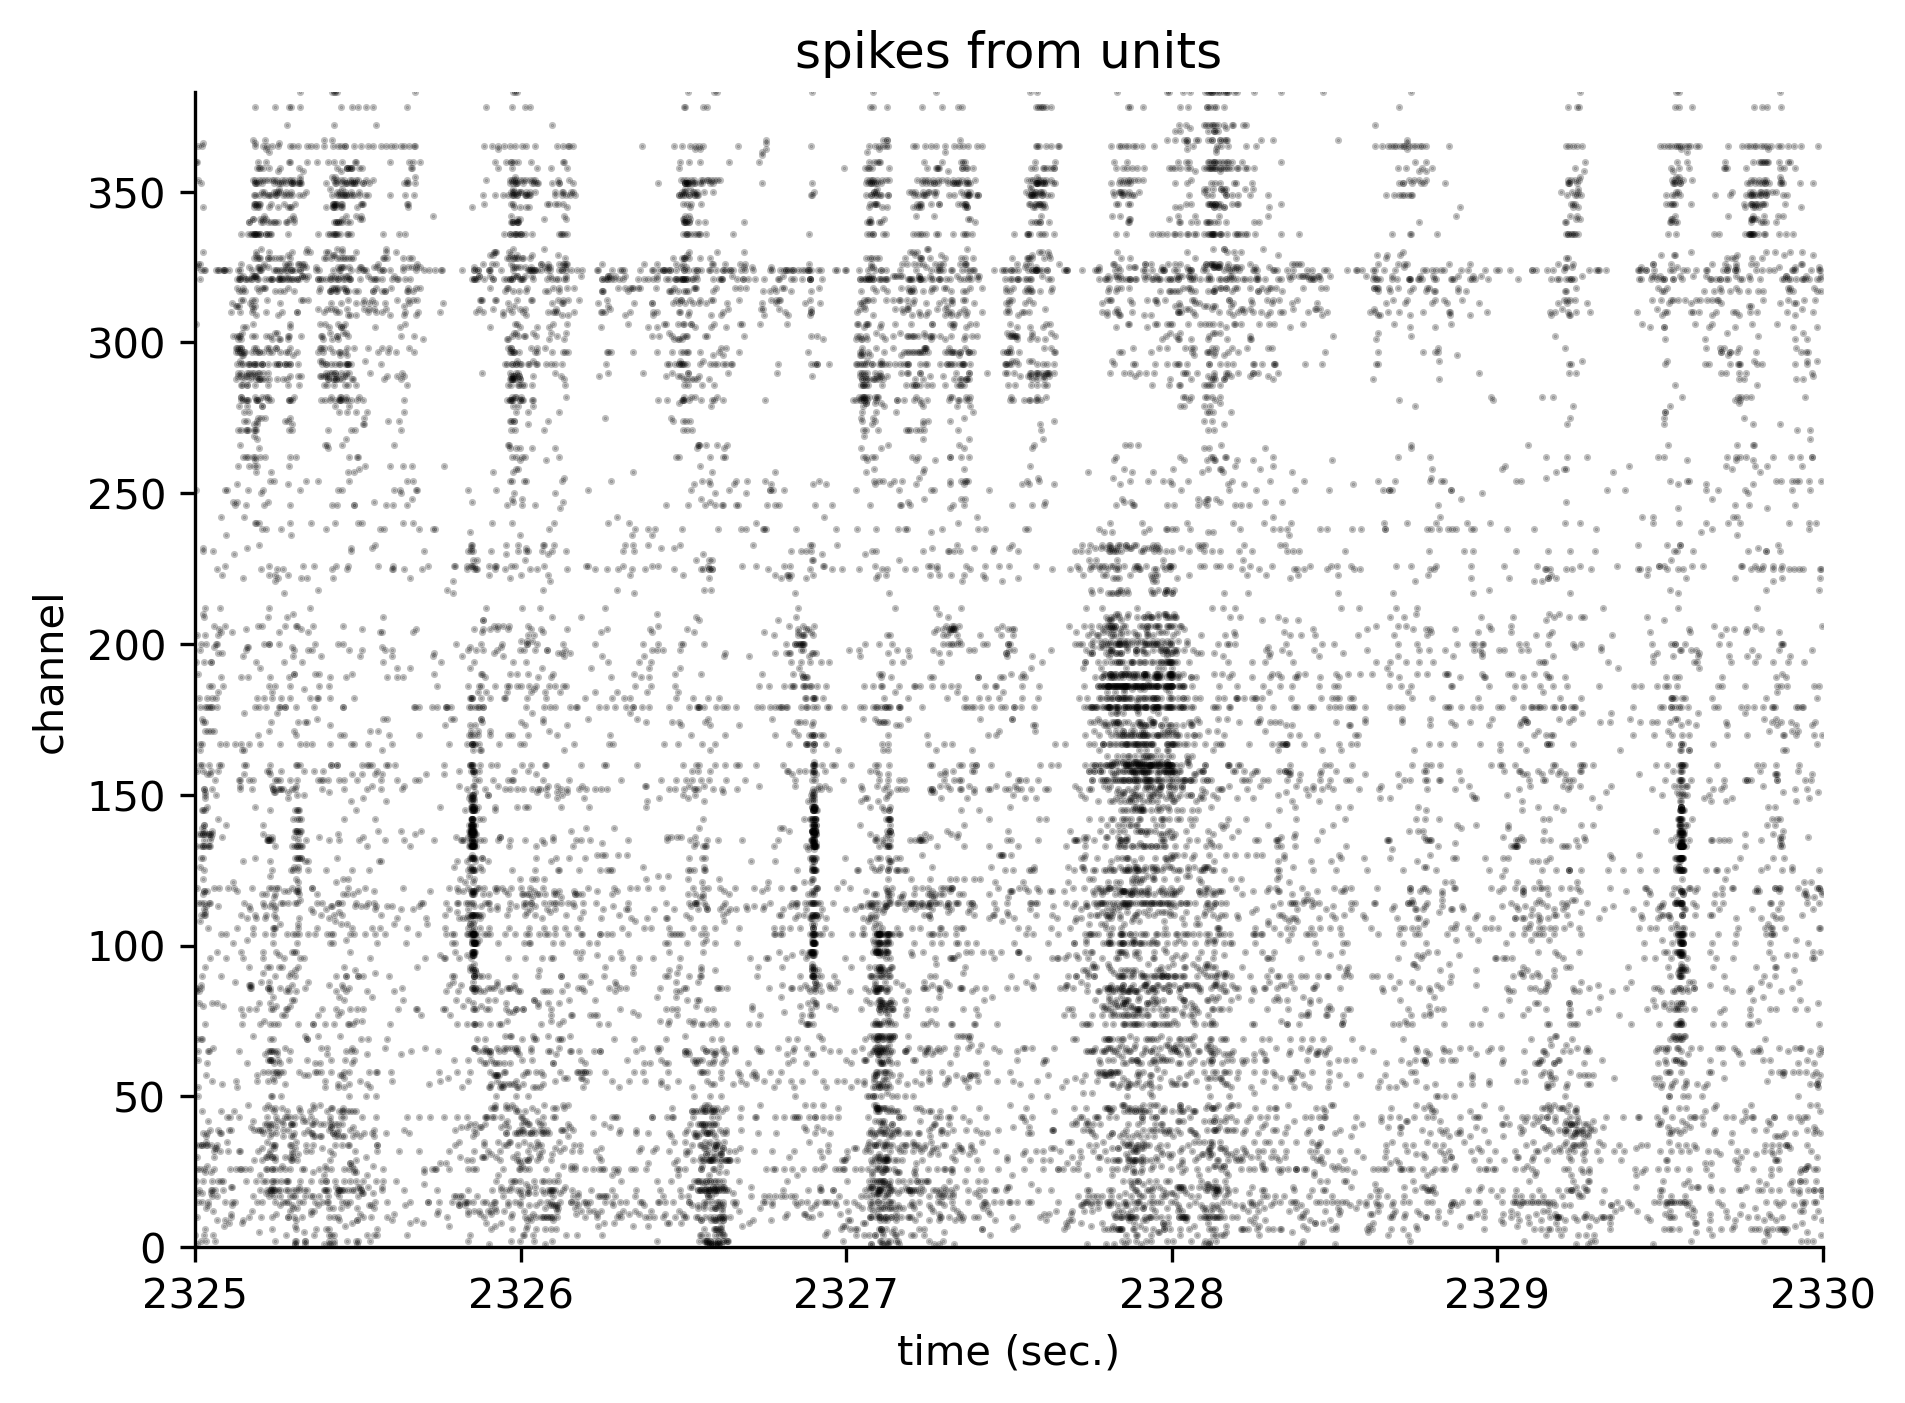

In [95]:
sec_start = 2325
sec_end = 2330

fig = plt.figure(figsize=(7,5), dpi=300)


t0 = np.nonzero(st > ops['fs']*sec_start)[0][0]
t1 = np.nonzero(st > ops['fs']*sec_end)[0][0]
plt.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
plt.xlim([sec_start, sec_end])
plt.ylim([0, chan_map.max()])
plt.xlabel('time (sec.)')
plt.ylabel('channel')
plt.title('spikes from units')

plt.savefig('./probe_analysis/raster_plots/'+dataset+'_probe_'+probe_id+'_spontaneous_end.pdf')


In [99]:
import os
import pyaldata as pyd
data_dir = '/data/mouse_data/processed/'+mouse_id+'/'+dataset+'/'
fname = os.path.join(data_dir, dataset+'_pyaldata.mat')
df = pyd.mat2dataframe(fname, shift_idx_fields=False, td_name='df')


/home/cf620/miniconda3/envs/quake/lib/python3.12/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


field sol_nb could not be converted to int.


In [134]:
event_times = df['event_time'].values/1000

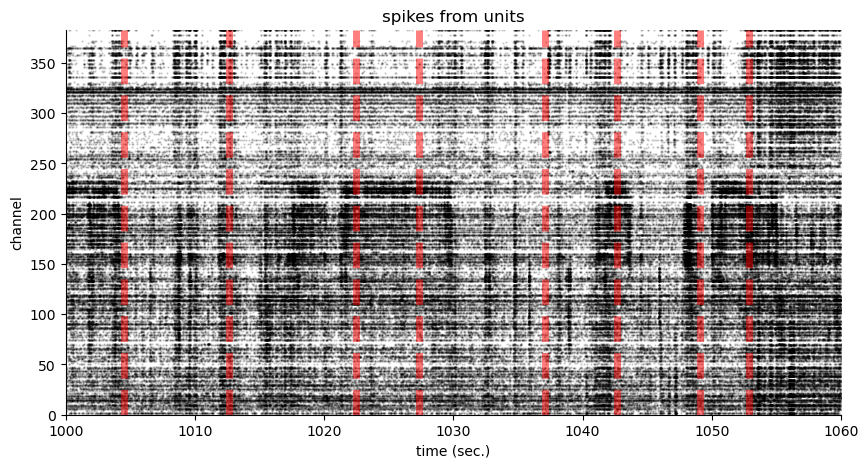

In [123]:
sec_start = 1000
sec_end = 1060

fig = plt.figure(figsize=(10,5), dpi=100)


t0 = np.nonzero(st > ops['fs']*sec_start)[0][0]
t1 = np.nonzero(st > ops['fs']*sec_end)[0][0]
plt.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.15)

vertical_lines = event_times[(event_times>=sec_start)&(event_times<=sec_end)]
for line in vertical_lines:
    plt.axvline(x=line, color='r', linestyle='--', linewidth=5, alpha = 0.5)
plt.xlim([sec_start, sec_end])
plt.ylim([ 0, chan_map.max()])
plt.xlabel('time (sec.)')
plt.ylabel('channel')
plt.title('spikes from units')

plt.savefig('./probe_analysis/raster_plots/'+dataset+'_probe_'+probe_id+'_perturbation.pdf')


In [106]:
vertical_lines

array([], dtype=float64)

In [24]:
t1

45308

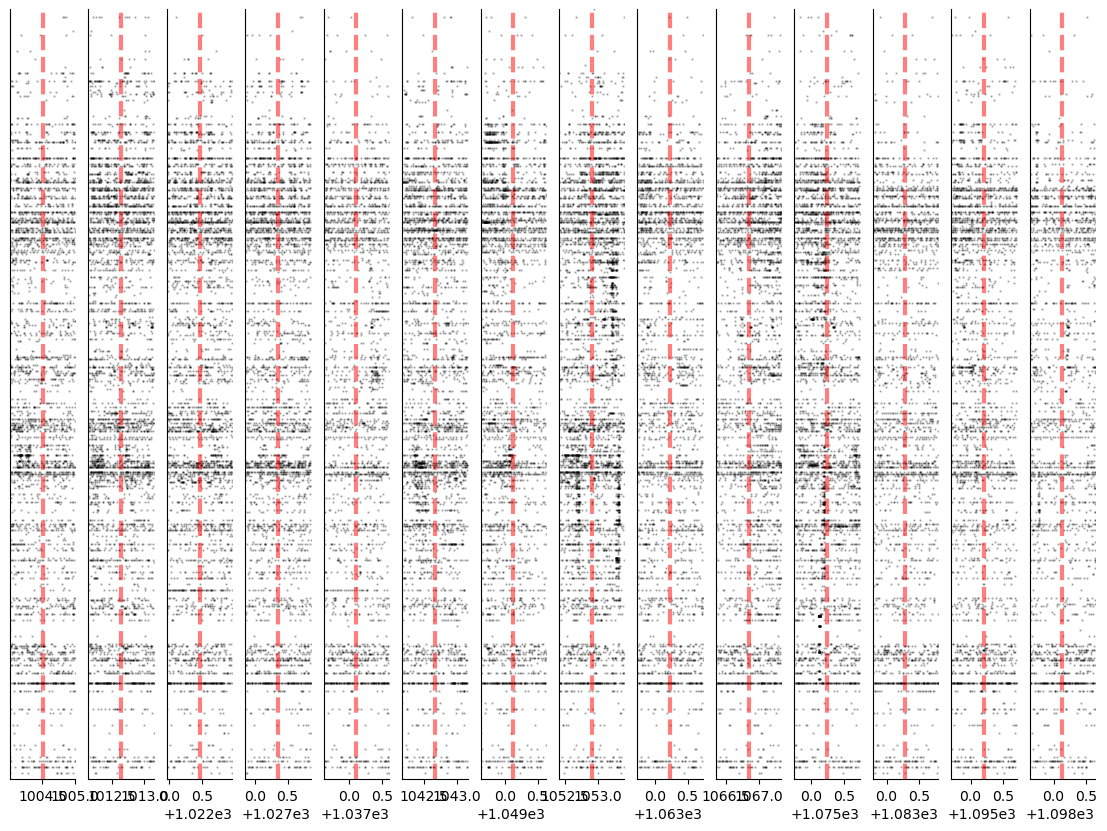

In [146]:
sec_start = 1000
sec_end = 1100

times = event_times[(event_times>=sec_start)&(event_times<=sec_end)]

fig, axs = plt.subplots(1, len(times), figsize=(14, 10))

axs = axs.flatten()

for i,t in enumerate(times):
    sec_start = t-0.5
    sec_end = t+0.5


    t0 = np.nonzero(st > ops['fs']*sec_start)[0][0]
    t1 = np.nonzero(st > ops['fs']*sec_end)[0][0]
    axs[i].scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)

    vertical_lines = event_times[(event_times>=sec_start)&(event_times<=sec_end)]
    for line in vertical_lines:
        axs[i].axvline(x=line, color='r', linestyle='--', linewidth=3, alpha = 0.5)
    axs[i].set_xlim([sec_start, sec_end])
    axs[i].set_ylim([ 0, chan_map.max()])
    axs[i].set_yticks([])
    #axs[i].set_xlabel('time (sec.)')
    #axs[i].set_ylabel('channel')
    #axs[i].set_title('spikes from units')

plt.savefig('./probe_analysis/raster_plots/'+dataset+'_probe_'+probe_id+'_perturbation.pdf')

# Firing rate distributions

In [78]:
dataset = 'M030_2024_04_11_17_00'
mouse_id = 'M030'

In [79]:
def plot_confidence_interval(x, values):
    mean = np.mean(values)
    stdev = np.std(values)

    top = mean - stdev
    bottom = mean + stdev
    plt.plot([x, x], [top, bottom], linewidth=3)
    plt.scatter(x, mean, s=30)

    return mean

def get_firing_rates(dataset, mouse_id, rec_0, rec_1):

    data_dir = '/data/mouse_data/processed/'+mouse_id+'/'+dataset+'/'+dataset+'_ephys/'+dataset+'_g0/'+dataset+'_g0_imec'+'0'+'/sorter_output/'
    chan_map =  np.load(data_dir+'channel_map.npy')
    templates =  np.load(data_dir+'templates.npy')
    chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
    chan_best = chan_map[chan_best]
    st = np.load(data_dir+'spike_times.npy')# time when spike happened. to transform into seconds 
    clu = np.load(data_dir+'spike_clusters.npy') # cluster identity of each spike
    firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()

    m1_neurons_firing_rates = firing_rates[chan_best<=rec_0]
    str_motor_neurons_firing_rates = firing_rates[chan_best>rec_0]


    data_dir = '/data/mouse_data/processed/'+mouse_id+'/'+dataset+'/'+dataset+'_ephys/'+dataset+'_g0/'+dataset+'_g0_imec'+'1'+'/sorter_output/'
    chan_map =  np.load(data_dir+'channel_map.npy')
    templates =  np.load(data_dir+'templates.npy')
    chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
    chan_best = chan_map[chan_best]
    st = np.load(data_dir+'spike_times.npy')# time when spike happened. to transform into seconds 
    clu = np.load(data_dir+'spike_clusters.npy') # cluster identity of each spike
    firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()

    s1_neurons_firing_rates = firing_rates[chan_best<=rec_1]
    str_sensor_neurons_firing_rates = firing_rates[chan_best>rec_1]

    return m1_neurons_firing_rates, str_motor_neurons_firing_rates, s1_neurons_firing_rates, str_sensor_neurons_firing_rates


    

In [80]:
m1_neurons_firing_rates, str_motor_neurons_firing_rates, s1_neurons_firing_rates, str_sensor_neurons_firing_rates = get_firing_rates(dataset, mouse_id, 210, 230)

<Figure size 1000x600 with 0 Axes>

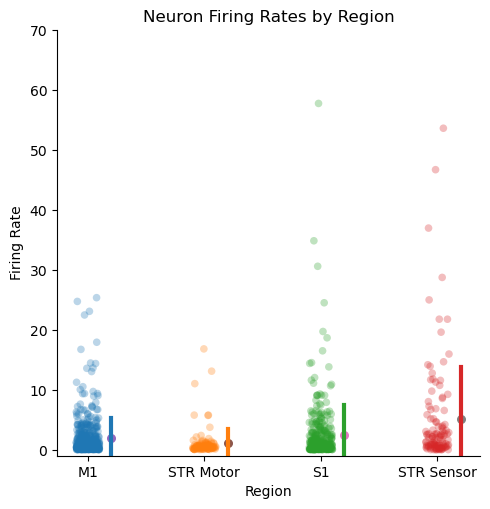

In [81]:
data = {
    'Firing Rate': list(m1_neurons_firing_rates) + list(str_motor_neurons_firing_rates) + list(s1_neurons_firing_rates) + list(str_sensor_neurons_firing_rates),
    'Region': ['M1'] * len(m1_neurons_firing_rates) + ['STR Motor'] * len(str_motor_neurons_firing_rates) +
              ['S1'] * len(s1_neurons_firing_rates) + ['STR Sensor'] * len(str_sensor_neurons_firing_rates)
}

df = pd.DataFrame(data)

# Create scatter plot using seaborn
plt.figure(figsize=(10, 6))
sns.catplot(data=df, x='Region', y='Firing Rate',s=30.0, hue='Region', alpha=0.30)

plot_confidence_interval(0.2, m1_neurons_firing_rates)
plot_confidence_interval(1.2, str_motor_neurons_firing_rates)
plot_confidence_interval(2.2, s1_neurons_firing_rates[s1_neurons_firing_rates<70])
plot_confidence_interval(3.2, str_sensor_neurons_firing_rates[str_sensor_neurons_firing_rates<70])


# Customize the plot
plt.gca().invert_yaxis()  # Invert y-axis if needed
plt.ylim([-1,70])
plt.title('Neuron Firing Rates by Region')
plt.xlabel('Region')
plt.ylabel('Firing Rate')

plt.savefig('./probe_analysis/firing_rates/'+dataset+'_firing_rates.pdf')